In [31]:
#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/?unapproved=601592&moderation-hash=d98f616a2939421833382d1e7772df57#comment-601592
import os
import time
import pandas as pd
from matplotlib import pyplot
import numpy as np
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

params = {
    "learning_rate" : [0.05, 0.1, 0.15, 0.20, 0.25, 0.3],
    "max_depth" : [3,4,5,6,8,10,12,15],
    "main_child_weight" : [1,2 ,3],
    "gamma" : [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

param_grid = {
        'silent': [False],
        'max_depth': [3,4,6,8, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

In [32]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators= 500,
                         learning_rate=0.1 ,max_depth=8, verbosity=0) # learning_rate=0.001, verbosity=0, booster="")
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [33]:
# load the dataset
file = "C:/Users/gurpr/Videos/BetaSci/Rossmann_Store1Noise50_1000-1500.csv"
pwd = os.getcwd()
os.chdir(os.path.dirname(file))
series = read_csv('Rossmann_Store1Noise50_1000-1500.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning and use n_in previous time steps
data = series_to_supervised(values, n_in=584)

In [34]:
print(series.shape)
print(values.shape)
print(data.shape)

(780, 1)
(780, 1)
(196, 585)


C:\Users\gurpr\anaconda3\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MAE: 654.817


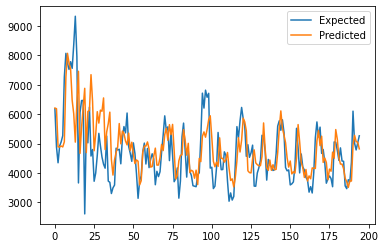

In [35]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 195)
rmse = mean_squared_error(y, yhat , squared=False)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [36]:
out = np.array(yhat, dtype=int)
out.round()
print(out)
df = pd.DataFrame({'Predicted Sales': out})
df.to_csv(r'C:\Users\gurpr\Videos\BetaSci\Xgboost_noise.csv', index=False, header=True)

[6206 6184 4883 4883 4914 4883 5059 7262 8068 7738 7522 6470 6008 5047
 6411 7458 4663 5558 6237 6878 4691 6092 6123 7342 6429 4754 5310 6083
 5695 6136 6097 6551 4796 5395 5675 6067 4459 3926 4444 4696 4884 5679
 4989 5423 5347 5086 4954 5354 4764 5044 4640 4318 4442 4397 3591 3736
 4710 4914 4913 5053 4814 4197 4217 4569 4843 4266 4267 4516 4968 4759
 5300 5520 5110 5642 5303 5650 4755 3792 3912 4414 4597 4617 5470 5114
 4603 5006 4014 4089 4056 3819 4094 3602 4493 4384 5243 5395 5215 5478
 5807 5943 5204 4395 4210 4365 4222 5193 4495 4494 4365 4455 4694 4152
 3743 3796 3522 3858 4408 5198 4712 5114 5863 5734 5433 4073 4011 4000
 4478 4784 4341 4279 4245 4246 4557 5700 4818 4178 4088 4439 4088 4279
 4105 4122 4693 5514 6109 5522 5289 5029 4509 4197 4404 3967 4038 3994
 4500 5644 5049 4365 4176 3846 4115 3723 3898 3800 4170 4157 4151 5084
 5442 4927 5248 4357 4507 4355 3767 4128 4058 4707 4499 5475 5145 4513
 4301 4299 4144 3815 3698 3506 3733 3723 4950 5279 5063 5046 4818]
